Jupyter notebook to calculate absorption, reflection, transmission 
with a TMM methods (capable of incoherence)

Modify d_perovskite to vary results and press SHIFT+enter until the code runs and you get a plot

In [1]:
d_perovskite = 700 
d_glass = 1e4
d_ITO = 110
d_c60 = 20
d_Ag = 200

Processed data for: air
Processed data for: glass
Processed data for: ITO
Processed data for: perovskite
Processed data for: C60
Processed data for: Ag
Processed data for: air
(7, 701)
Eg for Perovskite: 1.62 eV (at λ = 766.00 nm)


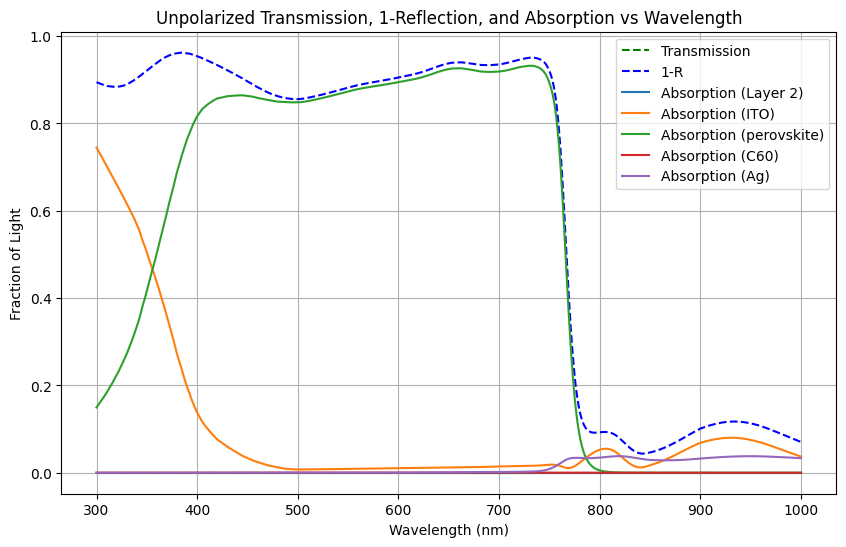

In [2]:
import numpy as np
from tmm_core import coh_tmm, absorp_in_each_layer, inc_tmm
import pandas as pd


# Layer thicknesses and names
d_list = [np.inf, d_glass, d_ITO, d_perovskite, d_c60, d_Ag, np.inf]
n_names = ['air', 'glass', 'ITO', 'perovskite', 'C60', 'Ag', 'air']
c_list = ['i', 'i', 'c', 'c', 'c', 'c', 'i'] 

# Initialize lists to hold trimmed arrays for each layer
wvl_arrays = []
n_complex_arrays = []
wvl = []
# Load the nk files and compute complex refractive index
for name in n_names:
    file_path = f'./nk/{name}.nk'  # Construct the file path
    try:
        # Read the data file, ignoring any extra columns
        df = pd.read_csv(file_path, sep='\t', usecols=[0, 1, 2], names=['wvl', 'n', 'k'], comment='#', header=None)
        
        # Convert to numeric, coercing errors to NaN
        df['n'] = pd.to_numeric(df['n'], errors='coerce')
        df['k'] = pd.to_numeric(df['k'], errors='coerce')
        df['wvl'] = pd.to_numeric(df['wvl'], errors='coerce')
        
        # Drop rows with NaN values
        df = df.dropna()
        
        # Slice rows 100:800 (inclusive of 100, exclusive of 801)
        df_trimmed = df.iloc[100:801]
        
        # Extract the wavelength and complex refractive index as simple NumPy arrays
        wvl_array = df_trimmed['wvl'].to_numpy()
        n_complex_array = (df_trimmed['n'] + 1j * df_trimmed['k']).to_numpy()
        
        # Append to the lists
        wvl_arrays.append(wvl_array)
        n_complex_arrays.append(n_complex_array)
        
        print(f"Processed data for: {name}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert the lists to arrays if needed
wvl_arrays = np.array(wvl_arrays, dtype=object)
n_complex_arrays = np.array(n_complex_arrays, dtype=object)
print (n_complex_arrays.shape)
wvl = wvl_arrays[1]

import numpy as np
import matplotlib.pyplot as plt
from tmm_core import inc_tmm, inc_absorp_in_each_layer

wavelengths = wvl
#print(len(d_list))
#print(len(c_list))
# Sanity check for c_list
if len(c_list) != len(d_list):
    raise ValueError("c_list must have the same length as d_list (number of layers).")
if not all(c in ['c', 'i'] for c in c_list):
    raise ValueError("c_list entries must be either 'c' (coherent) or 'i' (incoherent).")

# Example refractive index array (7 layers x 701 wavelengths)
#print("n_complex_arrays shape:", n_complex_arrays.shape)  # Verify shape (7, 701)
# Storage arrays
R_vals = []  # Polarization-averaged reflection
T_vals = []  # Polarization-averaged transmission
absorption_layers = []  # Polarization-averaged absorption per layer

# Loop over all wavelengths
for i, lam_vac in enumerate(wavelengths):
    # Extract refractive indices for all layers at the current wavelength
    n_list_for_lambda = n_complex_arrays[:, i].astype(complex)

    # Perform incoherent transfer matrix calculation for s-polarization
    inc_data_s = inc_tmm('s', n_list_for_lambda, d_list, c_list, th_0=0, lam_vac=lam_vac)
    R_s = inc_data_s['R']
    T_s = inc_data_s['T']
    absorption_s = inc_absorp_in_each_layer(inc_data_s)

    # Perform incoherent transfer matrix calculation for p-polarization
    inc_data_p = inc_tmm('p', n_list_for_lambda, d_list, c_list, th_0=0, lam_vac=lam_vac)
    R_p = inc_data_p['R']
    T_p = inc_data_p['T']
    absorption_p = inc_absorp_in_each_layer(inc_data_p)

    # Average reflection and transmission
    R_avg = (R_s + R_p) / 2
    T_avg = (T_s + T_p) / 2
    R_vals.append(R_avg)
    T_vals.append(T_avg)

    # Average absorption in intermediate layers
    absorption_avg = [(a_s + a_p) / 2 for a_s, a_p in zip(absorption_s[1:-1], absorption_p[1:-1])]
    absorption_layers.append(absorption_avg)

# Convert absorption to numpy array
absorption_layers = np.array(absorption_layers)  # Shape: (701, num_intermediate_layers)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Transmission
plt.plot(wavelengths, T_vals, label="Transmission", color="green", linestyle="--")

# Plot Reflection
plt.plot(wavelengths, [1 - R for R in R_vals], label="1-R", color="blue",  linestyle="--")

# Plot Absorption for each intermediate layer
for layer in range(absorption_layers.shape[1]):
    # Layer name from n_names (skip first and last layers for absorption)
    if 1 <= layer < len(n_names) - 1:
        label = f"Absorption ({n_names[layer+1]})"
    else:
        label = f"Absorption (Layer {layer+2})"
    
    # Mask invalid values (NaN or inf) and plot
    absorption_layer_data = absorption_layers[:, layer]
    absorption_layer_data = np.nan_to_num(absorption_layer_data, nan=0.0, posinf=0.0, neginf=0.0)
    
    plt.plot(wavelengths, absorption_layer_data, label=label)

    if n_names[layer + 1] == 'perovskite':
        
        # Step 1: Calculate the derivative of absorption for Perovskite
        absorption_derivative = np.gradient(absorption_layer_data, wavelengths)

        # Step 2: Find the index of the minimum derivative
        min_derivative_index = np.argmin(absorption_derivative)

        # Step 3: Get the corresponding wavelength
        min_wavelength = wavelengths[min_derivative_index]

        # Step 4: Calculate the bandgap Eg = 1240 / λ_min (in nm)
        Eg = 1240 / min_wavelength

        # Step 5: Print the result
        print(f"Eg for Perovskite: {Eg:.2f} eV (at λ = {min_wavelength:.2f} nm)")

# Add labels and legend
plt.xlabel("Wavelength (nm)")
plt.ylabel("Fraction of Light")
plt.title("Unpolarized Transmission, 1-Reflection, and Absorption vs Wavelength")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
